In [18]:
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

class ArgoverseForecastingLoader:   ## 用于加载 Arvergose 数据
    def __init__(self, root_dir: str):
        """Initialization function for the class.

        Args:
            root_dir: Path to the folder having sequence csv files
        """
        self.path_sequence = [os.path.join(root_dir, x) for x in os.listdir(root_dir)]
        self.len = len(self.path_sequence)

    def __len__(self) -> int:
        """Get the number of sequences in the data

        Returns:
            Number of sequences in the data
        """
        return self.len

    def get_df(self, csv_id: int) -> pd.DataFrame:
        """Get the dataframe for the specific sequence.

        Returns:
            pandas DataFrame for the specific sequence
        """
        return pd.read_csv(self.path_sequence[csv_id]).dropna()

In [19]:
root_dir = 'data'

afl = ArgoverseForecastingLoader(root_dir)
print('Total number of sequences:',len(afl))

for i in range(len(afl)): # 检查是否有非法数据（不为50个时间刻）
    df =  afl.get_df(i)
    if df[df['OBJECT_TYPE'] == 'AGENT'].shape[0] != 50:
        print(afl.path_sequence[i])


Total number of sequences: 3900


In [20]:
 def get_agent_traj(df: pd.DataFrame) -> np.ndarray:
    # 从 DataFrame 表中提取 AGENT 的 XY 坐标形成 np 数组
    
    agent_x = df[df["OBJECT_TYPE"] == "AGENT"]["X"]
    agent_y = df[df["OBJECT_TYPE"] == "AGENT"]["Y"]
    
    return np.column_stack((agent_x, agent_y))

In [21]:
def draw_trajectory(traj: np.ndarray):
    # 画出轨迹曲线
    ax = plt.gca()

    plt.plot(traj[0,0,0],traj[0,0,1],'-o',c='r')
    plt.plot(traj[0,:21,0],traj[0,:21,1],'-',c='b')

    for i in range(len(traj)):
        plt.plot(traj[i,20:,0],traj[i,20:,1],'-',c=np.random.rand(3,))
    plt.xlabel('map_x_coord (m)')
    plt.ylabel('map_y_coord (m)')
    ax.set_aspect('equal')
    plt.show()

In [22]:
def get_ade(forecasted_trajectory: np.ndarray, gt_trajectory: np.ndarray) -> float:
    """
    Returns:
        ade: Average Displacement Error
    """
    pred_len = forecasted_trajectory.shape[0]
    ade = float(
        sum(
            math.sqrt(
                (forecasted_trajectory[i, 0] - gt_trajectory[i, 0]) ** 2
                + (forecasted_trajectory[i, 1] - gt_trajectory[i, 1]) ** 2
            )
            for i in range(pred_len)
        )
        / pred_len
    )
    return ade

In [23]:
def get_fde(forecasted_trajectory: np.ndarray, gt_trajectory: np.ndarray) -> float:
    """
    Returns:
        fde: Final Displacement Error
    """
    fde = float(
            math.sqrt(
                (forecasted_trajectory[-1, 0] - gt_trajectory[-1, 0]) ** 2
                + (forecasted_trajectory[-1, 1] - gt_trajectory[-1, 1]) ** 2
            )
        )  
    return fde

In [24]:
def evaluation(afl, prediction, fast_run=False):
    total = len(afl) if not fast_run else int(len(afl) / 20)
    minADE = 0
    minFDE = 0
    for i in range(total):
        print('\r'+str(i + 1)+'/'+str(total),end="")
        df = afl.get_df(i)
        gt_traj = get_agent_traj(df)
        predict_traj_list = prediction(df)
        minADE += min([get_ade(gt_traj, predict_traj) for predict_traj in predict_traj_list])
        minFDE += min([get_fde(gt_traj, predict_traj) for predict_traj in predict_traj_list])
    minADE /= total
    minFDE /= total
    return {
        "minADE": minADE,
        "minFDE": minFDE
    }

data/3304.csv


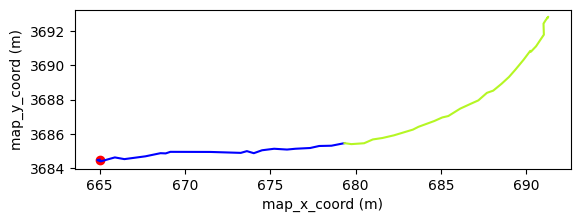

,TIMESTAMP,TRACK_ID,OBJECT_TYPE,X,Y,CITY_NAME
0,3.159712e+08,00000000-0000-0000-0000-000000000000,AV,680.789861,3724.021679,MIA
1,3.159712e+08,00000000-0000-0000-0000-000000064851,OTHERS,684.471377,3705.679509,MIA
2,3.159712e+08,00000000-0000-0000-0000-000000064891,OTHERS,689.743249,3775.376918,MIA
3,3.159712e+08,00000000-0000-0000-0000-000000064921,OTHERS,661.571695,3777.865899,MIA
4,3.159712e+08,00000000-0000-0000-0000-000000064221,OTHERS,687.012922,3729.134512,MIA


In [25]:
print(afl.path_sequence[480])
df_demo = afl.get_df(480)
draw_trajectory(np.array([get_agent_traj(df_demo)]))

df_demo.head()

In [26]:
def prediction_baseline(df: pd.DataFrame, past_points=20, pred_points=30):
    # 根据最近时刻速度匀速直线运动

    df = df[df["OBJECT_TYPE"] == "AGENT"][["X", "Y"]]
    trajectory = df.iloc[:past_points].to_numpy()

    velocity_x = trajectory[-1, 0] - trajectory[-2, 0]
    velocity_y = trajectory[-1, 1] - trajectory[-2, 1]

    result = np.zeros((past_points + pred_points, 2))
    result[:past_points] = trajectory
    
    for i in range(pred_points):
        result[past_points + i] = result[past_points + i - 1] + np.array([velocity_x, velocity_y])
    
    return np.array([result])

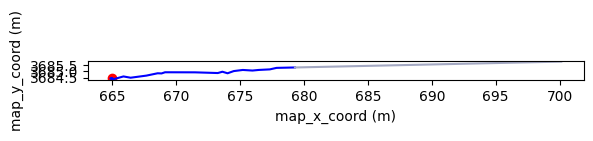

195/195{'minADE': 2.4467279934752173, 'minFDE': 8.588768259439037}


In [27]:
predict_traj = prediction_baseline(df_demo)
draw_trajectory(predict_traj)

print(evaluation(afl, prediction_baseline, fast_run=True))

In [28]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

regressor = LinearRegression
# regressor = RandomForestRegressor
# regressor = SVR

def prediction_regression(df: pd.DataFrame, past_points=20, pred_points=30, calc_points=20, regressor=regressor):
    # a prediction function that predict by linear/random forest regression

    df = df[df["OBJECT_TYPE"] == "AGENT"][["X", "Y"]]
    trajectory = df.iloc[:past_points].to_numpy()

    time_steps = np.arange(past_points - calc_points, past_points).reshape(-1, 1)
    model_x = regressor().fit(time_steps, trajectory[-calc_points:, 0])
    model_y = regressor().fit(time_steps, trajectory[-calc_points:, 1])

    pred_time_steps = np.arange(past_points, past_points + pred_points).reshape(-1, 1)
    pred_x = model_x.predict(pred_time_steps)
    pred_y = model_y.predict(pred_time_steps)

    pred_trajectory = np.column_stack((pred_x, pred_y))
    result = np.vstack((trajectory, pred_trajectory))

    return np.array([result])

In [29]:
from functools import partial

result = []
for i in range(2, 21):
    print(f"\r            calc_points = {i}", end="")
    eval_result = evaluation(afl, partial(prediction_regression, calc_points=i), fast_run=True)
    result.append({
        "calc_points": i,
        "minADE": eval_result['minADE'],
        "minFDE": eval_result['minFDE']
    })
result_df = pd.DataFrame(result)

6/195       calc_points = 2

195/195     calc_points = 20

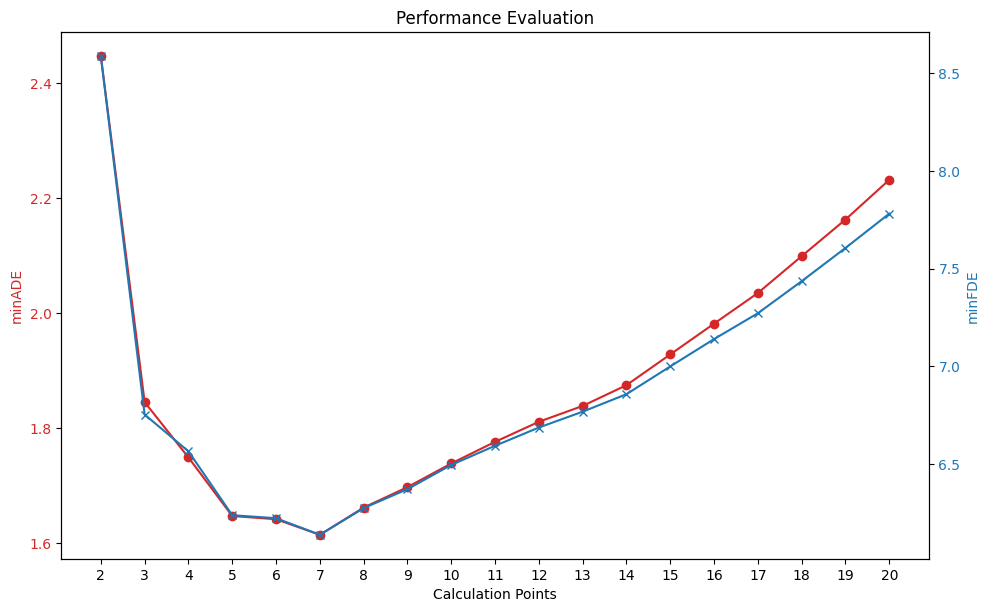

In [30]:
fig, ax1 = plt.subplots(figsize=(10, 6))

color = 'tab:red'
ax1.set_xlabel('Calculation Points')
ax1.set_ylabel('minADE', color=color)
ax1.plot(result_df['calc_points'], result_df['minADE'], label='minADE', marker='o', color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax1.set_xticks(range(2, 21))

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('minFDE', color=color)
ax2.plot(result_df['calc_points'], result_df['minFDE'], label='minFDE', marker='x', color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.title('Performance Evaluation')
plt.show()

[[[ 665.01095085 3684.47284966]
  [ 664.86636059 3684.45375734]
  [ 665.06293666 3684.37872654]
  [ 665.89276206 3684.6092429 ]
  [ 666.45015103 3684.50935833]
  [ 667.68389391 3684.67367909]
  [ 668.56551237 3684.85698307]
  [ 668.87171404 3684.84478008]
  [ 669.14265511 3684.93585937]
  [ 671.48485458 3684.93015794]
  [ 673.26977251 3684.87560483]
  [ 673.62789591 3684.97733472]
  [ 674.03347638 3684.85698668]
  [ 674.51636911 3685.02843153]
  [ 675.22365568 3685.11665408]
  [ 675.98083183 3685.07028054]
  [ 676.47162279 3685.11716647]
  [ 677.33449394 3685.16071855]
  [ 677.86402478 3685.27904062]
  [ 678.58207633 3685.2948448 ]
  [ 679.25779949 3685.32594107]
  [ 679.93035385 3685.36931431]
  [ 680.6029082  3685.41268756]
  [ 681.27546256 3685.4560608 ]
  [ 681.94801691 3685.49943405]
  [ 682.62057127 3685.5428073 ]
  [ 683.29312563 3685.58618054]
  [ 683.96567998 3685.62955379]
  [ 684.63823434 3685.67292704]
  [ 685.31078869 3685.71630028]
  [ 685.98334305 3685.75967353]
  [ 686.

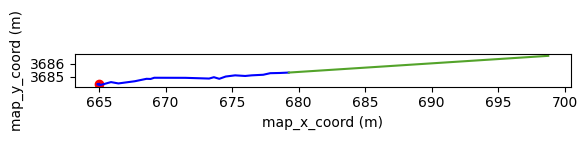

In [31]:
predict_traj = prediction_regression(df_demo, calc_points=7)

print(predict_traj)
draw_trajectory(predict_traj)

In [32]:
# regressor = LinearRegression
# regressor = RandomForestRegressor
regressor = SVR

def get_nearest_obstacle(df):
    # 初始化NEAREST_OBSTACLE列
    df['NEAREST_OBSTACLE'] = np.inf
    
    for index, row in df.iterrows():
        # 提取当前轨迹点的预测位置
        df_tmp = df[df['TIMESTAMP'] == row['TIMESTAMP']]
        current_predicted_x = row['X']
        current_predicted_y = row['Y']
        
        # 计算与其他轨迹点的L2距离
        distances = np.sqrt((df_tmp['X'] - current_predicted_x)**2 + (df_tmp['Y'] - current_predicted_y)**2)
        
        # 排除当前轨迹点自身
        distances[index] = np.inf
        
        # 更新NEAREST_OBSTACLE值
        df.at[index, 'NEAREST_OBSTACLE'] = distances.min()
        if np.isinf(df.at[index, 'NEAREST_OBSTACLE']):
            df.at[index, 'NEAREST_OBSTACLE'] = 0
    
    return df

def get_feature(init_df: pd.DataFrame, length=50) -> pd.DataFrame:
    df = init_df.copy()
    df = df[df['OBJECT_TYPE']=='AGENT']
    df = df.head(length)

    # 计算速度并处理NaN
    df['VELOCITY_X'] = df.groupby('TRACK_ID')['X'].diff().fillna(method='ffill').fillna(method='bfill').fillna(0)
    df['VELOCITY_Y'] = df.groupby('TRACK_ID')['Y'].diff().fillna(method='ffill').fillna(method='bfill').fillna(0)

    # 计算平均速度
    df['MEAN_VELOCITY_X'] = df.groupby('TRACK_ID')['VELOCITY_X'].transform(lambda x: x.mean())
    df['MEAN_VELOCITY_Y'] = df.groupby('TRACK_ID')['VELOCITY_Y'].transform(lambda x: x.mean())

    # 计算加速度并处理NaN
    df['ACCELERATION_X'] = df.groupby('TRACK_ID')['VELOCITY_X'].diff().fillna(method='ffill').fillna(method='bfill').fillna(0)
    df['ACCELERATION_Y'] = df.groupby('TRACK_ID')['VELOCITY_Y'].diff().fillna(method='ffill').fillna(method='bfill').fillna(0)

    # 计算平均加速度
    df['MEAN_ACCELERATION_X'] = df.groupby('TRACK_ID')['ACCELERATION_X'].transform(lambda x: x.mean())
    df['MEAN_ACCELERATION_Y'] = df.groupby('TRACK_ID')['ACCELERATION_Y'].transform(lambda x: x.mean())

    # 计算角动量和平均角动量
    df['ANGULAR_MOMENTUM'] = df['VELOCITY_X'] * df['ACCELERATION_Y'] - df['VELOCITY_Y'] * df['ACCELERATION_X']
    df['MEAN_ANGULAR_MOMENTUM'] = df.groupby('TRACK_ID')['ANGULAR_MOMENTUM'].transform(lambda x: x.mean())

    # 获取最近障碍物的信息
    df = get_nearest_obstacle(df)

    return df

# get_feature(df_demo).head()

In [33]:
M = 6
train = 0.5
feature_used = ['VELOCITY_X', 'VELOCITY_Y', 'MEAN_VELOCITY_X', 'MEAN_VELOCITY_Y', 'ACCELERATION_X', 'ACCELERATION_Y','MEAN_ACCELERATION_X','MEAN_ACCELERATION_Y','ANGULAR_MOMENTUM','MEAN_ANGULAR_MOMENTUM', 'NEAREST_OBSTACLE']
# 预设值参数，可进行消融实验

def train_model(afl, M):
    features_list = []
    targets_list = []
    
    for i in range(int(0.05 * len(afl)), int((0.05 + train) * len(afl))):   # 控制训练数据的百分比（验证数据为前5%）
        df = afl.get_df(i)
        df = get_nearest_obstacle(df)
        df = get_feature(df)
        
        if len(df) - M - 2 <= 0:
            continue
        
        for start_idx in range(2, len(df) - M):
            end_idx = start_idx + M
            features = df.iloc[start_idx:end_idx][feature_used].to_numpy().flatten()
            target = df.iloc[end_idx][['VELOCITY_X', 'VELOCITY_Y']].to_numpy()
            features_list.append(features)
            targets_list.append(target)
    
    # 将列表转换为NumPy数组
    features_array = np.array(features_list)
    targets_array = np.array(targets_list)
    
    # 训练模型
    model_x = regressor().fit(features_array, targets_array[:, 0])
    model_y = regressor().fit(features_array, targets_array[:, 1])
    
    return model_x, model_y

model_x, model_y = train_model(afl, M)

In [ ]:
def prediction_regression_2(init_df: pd.DataFrame, past_points=20, pred_points=30):
    # 确保df已经包含了起始的特征
    init_df = init_df.copy()
    init_df = get_nearest_obstacle(init_df)
    df = get_feature(init_df, past_points)

    # 使用最后M个时间点的特征作为初始特征
    for i in range(pred_points):
        # 获取最后一个时间点的特征
        last_features = df.iloc[-M:][feature_used].to_numpy().flatten().reshape(1, -1)
        
        # 预测下一个时间点的速度
        next_velocity_x = model_x.predict(last_features)
        next_velocity_y = model_y.predict(last_features)
    
        next_position_x = df.iloc[-1]['X'] + next_velocity_x
        next_position_y = df.iloc[-1]['Y'] + next_velocity_y
        
        new_row = pd.DataFrame({'X': next_position_x, 'Y': next_position_y, 'TRACK_ID': df.iloc[0]['TRACK_ID'], 'OBJECT_TYPE': 'AGENT'})
        df = pd.concat([df, new_row], ignore_index=True)
        df = get_feature(df, past_points + i + 1)

    # 将预测的位置转换为NumPy数组并返回
    return np.array([df[['X','Y']].to_numpy()])

[[[ 665.01095085 3684.47284966]
  [ 664.86636059 3684.45375734]
  [ 665.06293666 3684.37872654]
  [ 665.89276206 3684.6092429 ]
  [ 666.45015103 3684.50935833]
  [ 667.68389391 3684.67367909]
  [ 668.56551237 3684.85698307]
  [ 668.87171404 3684.84478008]
  [ 669.14265511 3684.93585937]
  [ 671.48485458 3684.93015794]
  [ 673.26977251 3684.87560483]
  [ 673.62789591 3684.97733472]
  [ 674.03347638 3684.85698668]
  [ 674.51636911 3685.02843153]
  [ 675.22365568 3685.11665408]
  [ 675.98083183 3685.07028054]
  [ 676.47162279 3685.11716647]
  [ 677.33449394 3685.16071855]
  [ 677.86402478 3685.27904062]
  [ 678.58207633 3685.2948448 ]
  [ 679.3446694  3685.38077534]
  [ 680.08403533 3685.44950663]
  [ 680.82807007 3685.53409516]
  [ 681.60382085 3685.62345138]
  [ 682.39538294 3685.71634569]
  [ 683.19987589 3685.8190657 ]
  [ 684.01550195 3685.92584993]
  [ 684.84175766 3686.03993251]
  [ 685.67843798 3686.15950502]
  [ 686.52622998 3686.28588852]
  [ 687.38273931 3686.4177281 ]
  [ 688.

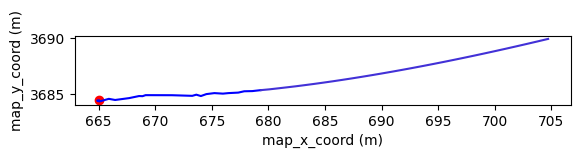

195/195{'minADE': 1.6273483565634324, 'minFDE': 6.157272239307956}


In [ ]:
predict_traj = prediction_regression_2(df_demo)
print(predict_traj)
draw_trajectory(predict_traj)

print(evaluation(afl, partial(prediction_regression_2), fast_run=True))

In [ ]:
# 测试集

# from lib.competition_util import generate_forecasting_h5

# afl_test = ArgoverseForecastingLoader("/mnt/d/dataset/Argoverse/test_obs/data")
# output_all = {}
# for i in range(len(afl_test)):
#     print('\r'+str(i + 1)+'/'+str(len(afl_test)),end="")
#     data = afl_test.get_df(i)
#     predict_traj = prediction_baseline_multi(data)
#     seq_id = int(os.path.basename(afl_test.path_sequence[i])[:-4])
#     output_all[seq_id] = predict_traj[:,20:,:]

In [ ]:
# output_path = 'competition_files/'
# generate_forecasting_h5(output_all, output_path) #this might take awhile